In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from ipywidgets import widgets, interactive
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from adjustText import adjust_text
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error,r2_score
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Reading the data
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv', parse_dates=['date'])
df

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand
0,AFG,Asia,Afghanistan,2019-12-31,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
1,AFG,Asia,Afghanistan,2020-01-01,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
2,AFG,Asia,Afghanistan,2020-01-02,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
3,AFG,Asia,Afghanistan,2020-01-03,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
4,AFG,Asia,Afghanistan,2020-01-04,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23077,NaN,NaN,International,2020-02-28,705,0,4,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23078,NaN,NaN,International,2020-02-29,705,0,6,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23079,NaN,NaN,International,2020-03-01,705,0,6,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23080,NaN,NaN,International,2020-03-02,705,0,6,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df1 = df.groupby(['location']).agg({'new_cases': ['sum'], 'new_deaths' : ['sum'], 'new_tests' : ['sum']})
df1.columns=['TotalCases', 'TotalDeaths', 'TotalTests']
df1 = df1.reset_index()
df1['TotalTests'] = df1['TotalTests'].astype('int64')
df1.sort_values(by=['TotalCases'], inplace=True, ascending=False)
df1 = df1.head(11)


cm = sns.light_palette("green", as_cmap=True)

s =df1.style.background_gradient(cmap=cm)
s


,location,TotalCases,TotalDeaths,TotalTests
208,World,7210462,411195,0
200,United States,1979850,112006,6970305
27,Brazil,739503,38406,0
158,Russia,485253,6141,13119988
199,United Kingdom,289140,40883,2759512
90,India,276583,7745,4781228
178,Spain,241966,27136,0
98,Italy,235561,34043,4314326
151,Peru,203736,5738,133846
73,Germany,184861,8729,0


In [4]:
countries = ['United States', 'China', 'Italy', 'Spain', 'Germany', 'France', 'Iran', 'United Kingdom', 'Turkey', 'Russia', 'Brazil']
df = df[df['location'].isin(countries)]

#pivoting Data
data = df.pivot(index='date', columns='location', values='total_cases')
countries = list(data.columns)
covid = data.reset_index('date')
covid.set_index(['date'], inplace=True)
covid.columns = countries

#displaying data
covid.head()


,Brazil,China,France,Germany,Iran,Italy,Russia,Spain,Turkey,United Kingdom,United States
date,,,,,,,,,,,
2019-12-31,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
2020-01-01,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
2020-01-02,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
2020-01-03,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
2020-01-04,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


Text(2020-01-01 00:00:00, 2029855, 'COVID-19 Cases detected by Country')

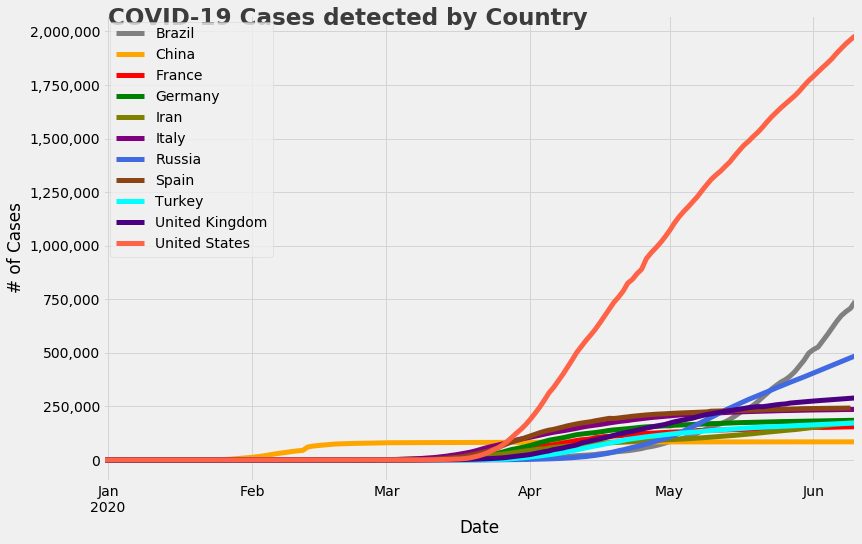

In [5]:
# Section 6 - Generating Colours and Style
colors = {'Brazil': 'grey', 'China': 'orange', 'France': 'red', 'Germany': 'green', 'Iran': 'olive', 'Italy': 'purple', 'Russia': 'royalblue', 'Spain': 'saddlebrown', 'Turkey': 'aqua', 'United Kingdom' : 'indigo', 'United States': 'tomato'}
plt.style.use('fivethirtyeight')

# Section 7 - Creating the Visualization
plot = covid.plot(figsize=(12,8), color=list(colors.values()), linewidth=5, legend=True)
plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plot.grid(color='#d4d4d4')
plot.set_xlabel('Date')
plot.set_ylabel('# of Cases')

# Section 8 - Assigning Colour
#for country in list(colors.keys()):
    #plot.text(x = covid.index[-1], y = covid[country].max(), color = colors[country], s = country)

plot.text(x = covid.index[1], y = int(covid.max().max())+50005, s = "COVID-19 Cases detected by Country", fontsize = 23, weight = 'bold', alpha = .75)
#plot.text(x = covid.index[1], y = int(covid.max().max()), s = "For the top 10 most affected Countries ", fontsize = 16, alpha = .75)




In [25]:
df2 = df.groupby(['location']).agg({'new_cases': ['sum'], 'new_deaths' : ['sum']})
df2.columns=['TotalCases', 'TotalDeaths']
df2 = df2.reset_index()
df2['PercentageDeaths'] = (df2['TotalDeaths']/df2['TotalCases']) * 100
df2.sort_values(by=['PercentageDeaths'], inplace=True)
df2.head(11)


,location,TotalCases,TotalDeaths,PercentageDeaths
6,Russia,262843,2418,0.919941
8,Turkey,146457,4055,2.768731
3,Germany,173772,7881,4.535253
1,China,84038,4637,5.517742
4,Iran,116635,6902,5.917606
10,United States,1443397,87568,6.066799
0,Brazil,218223,14817,6.789843
7,Spain,230183,27459,11.929204
5,Italy,223885,31610,14.118856
9,United Kingdom,236711,33998,14.362662


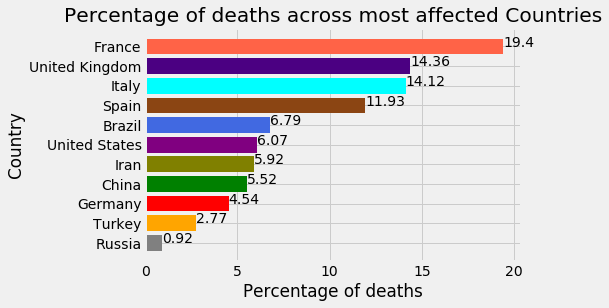

In [26]:
df2['PercentageDeaths']= df2['PercentageDeaths'].round(2)
plt.barh(df2['location'], df2['PercentageDeaths'], color = list(colors.values()))
for index, value in enumerate(df2['PercentageDeaths']):
    plt.text(value, index, str(value))
plt.xlabel("Percentage of deaths")
plt.ylabel("Country")
plt.title("Percentage of deaths across most affected Countries")

plt.show()

In [27]:
df3 = df
df3['new_tests_per_million'] = df3['new_tests_per_thousand']*1000
area = widgets.Dropdown(
    options=['All'] + list(df3['location'].unique()),
    value='All',
    description='Country:',
)

def plotit(area):
    df4 = df3.copy()
    if area != 'All':
        df4 = df4[df4.location == area]
    # Add x-axis and y-axis
    ax = df4.plot(x="date", y="new_cases_per_million", color= "purple", figsize=(8,8))
    df4.plot(x="date", y="new_tests_per_million", ax=ax, color="olive")

# Set title and labels for axes
    ax.set(xlabel="Date",
       ylabel="measure",
       title="Testing v/s Cases detected")

# Define the date format
    #date_form = DateFormatter("%m-%y")
    #ax.xaxis.set_major_formatter(date_form)    

interactive(plotit, area=area)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


interactive(children=(Dropdown(description='Country:', options=('All', 'Brazil', 'China', 'Germany', 'Spain', …

coefficient of determination: 0.7830325648246557


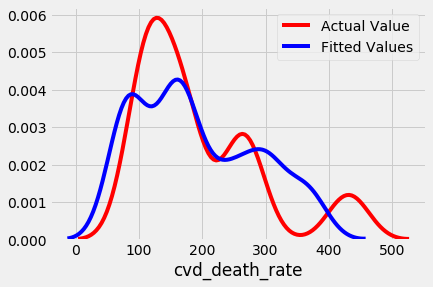

In [43]:
#Splitting Data into training and test
df = df.dropna(subset=['cvd_death_rate', 'median_age','female_smokers', 'male_smokers','population_density', 'extreme_poverty'])
y=df['cvd_death_rate']
#x=df[['population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'diabetes_prevalence', 'female_smokers', 'male_smokers','hospital_beds_per_100k','extreme_poverty']]
x=df[['median_age','female_smokers', 'male_smokers','population_density', 'extreme_poverty']]
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size=0.3)


#Fitting into a linear regression model
lm = LinearRegression()
lm.fit(x_train,y_train)
predictions=lm.predict(x_test)
df4= pd.DataFrame({'Actual': y_test,'predicted': predictions,})

#Calculating test error
r_sq = lm.score(x, y)
print('coefficient of determination:', r_sq)

ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(predictions, hist=False, color="b", label="Fitted Values" , ax=ax1)

In [44]:
US = df.loc[df['location'] == 'United States']
US = US.loc[:,['date', 'new_cases']]
US = US.reset_index()
US.head()

def forcast_plot_WMA(train,valid):
    
    plt.style.use("fivethirtyeight")
    
    train.set_index('date')['new_cases'].plot(figsize=(12, 10), linewidth=2.5, color='Black')
    valid.set_index('date')['cases_Weighted_MA'].plot(figsize=(12, 10), linewidth=2.5, color='Orange')
    plt.xlabel('Datetime')
    plt.ylabel('#Cases')
    plt.legend(['Training','Validation'])
    plt.show()
    
def Weighted_average(data,k,weights):
    if (k != len(weights)):
        print("Error: Value of K is not equal to number of Weights or sum of weights equals 1")
    else:
        df = pd.DataFrame(data)
        #weights = np.array([0.5, 0.25, 0.25])
        sum_weights = np.sum(weights)
    
        data['cases_Weighted_MA'] = (data['new_cases'].rolling(window=k, center=True).apply(lambda x: np.sum(weights*x) / sum_weights, raw=False))
        
        train = data[(data.date <= 'APR 10 2020') & (data.date >= 'JAN 01 2020')] 
        valid = data[(data.date <= 'MAY 31 2020') & (data.date >= 'APR 11 2020')] 
    #plotting
    train = data[(data.date <= 'MAY 10 2020') & (data.date >= 'JAN 01 2020')] 
    valid = data[(data.date <= 'MAY 31 2020') & (data.date >= 'APR 11 2020')] 
    forcast_plot_WMA(train,valid)

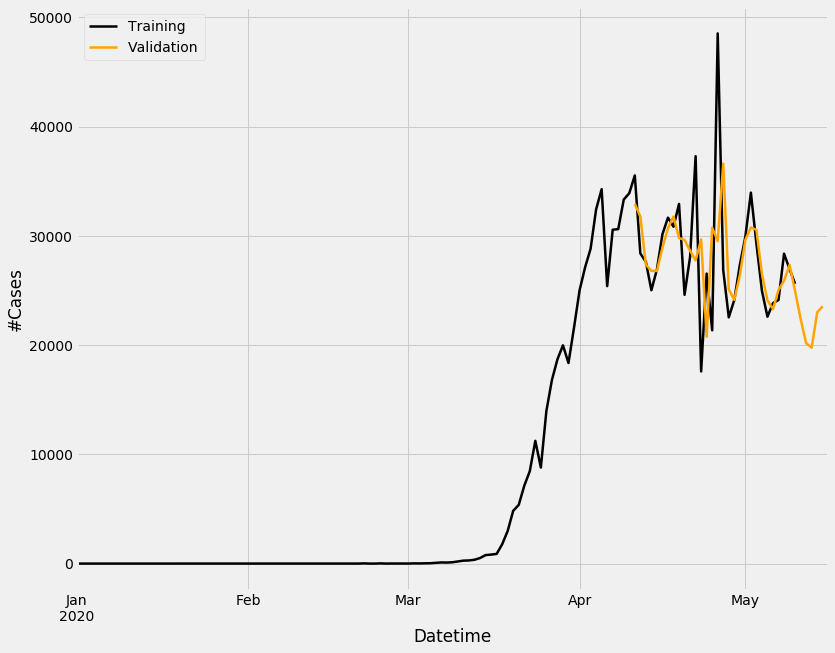

In [40]:
optimum_func(US,3,[0.5,0.25,0.25])

Fit ARIMA: order=(0, 1, 0); AIC=2351.644, BIC=2357.219, Fit time=0.030 seconds
Fit ARIMA: order=(0, 1, 1); AIC=2312.614, BIC=2320.976, Fit time=0.093 seconds
Fit ARIMA: order=(0, 1, 2); AIC=2313.631, BIC=2324.781, Fit time=0.087 seconds
Fit ARIMA: order=(0, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0); AIC=2320.709, BIC=2329.071, Fit time=0.029 seconds
Fit ARIMA: order=(1, 1, 1); AIC=2313.715, BIC=2324.865, Fit time=0.113 seconds
Fit ARIMA: order=(1, 1, 2); AIC=2313.981, BIC=2327.918, Fit time=0.066 seconds
Fit ARIMA: order=(1, 1, 3); AIC=2315.326, BIC=2332.051, Fit time=0.100 seconds
Fit ARIMA: order=(1, 1, 4); AIC=2285.212, BIC=2304.725, Fit time=0.331 seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=0.251 seconds
Fit ARIMA: order=(2, 1, 0); AIC=2320.108, BIC=2331.258, Fit time=0.087 seconds
Fit ARIMA: order=(2

(array([737425., 737446., 737456., 737477., 737485., 737506., 737516.,
        737537., 737546., 737567.]), <a list of 10 Text xticklabel objects>)

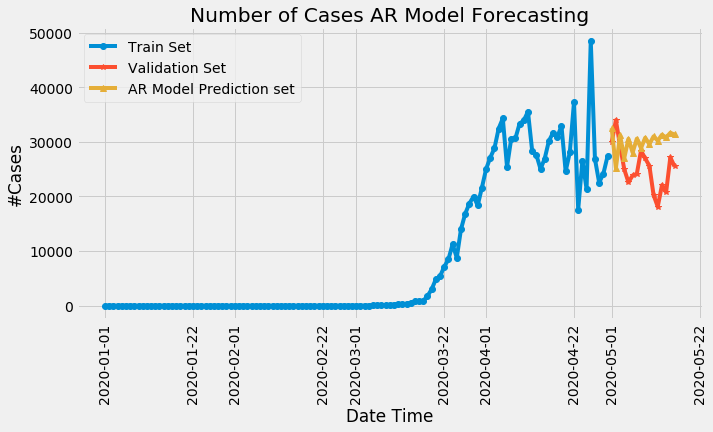

In [38]:
US = df.loc[df['location'] == 'United States']
US.reset_index()
US.head()

data= US
data = data.set_index('date')
train = data[(data.index <= 'APR 30 2020') & (data.index >= 'JAN 01 2020')] 
valid = data[(data.index <= 'MAY 31 2020') & (data.index >= 'MAY 01 2020')] 
y_pred=valid.copy()

model_ar= auto_arima(train["new_cases"],trace=True, error_action='ignore', start_p=0, start_q=0,max_p=5,max_q=5, m=30,suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(train["new_cases"])


prediction_ar=model_ar.predict(len(valid))
y_pred["AR Model Prediction"]=prediction_ar


print("Root Mean Square Error for MA Model: ",np.sqrt(mean_squared_error(y_pred["new_cases"],y_pred["AR Model Prediction"])))

plt.figure(figsize=(10,5))
plt.plot(train.index,train["new_cases"],label="Train Set",marker='o')
plt.plot(valid.index,valid["new_cases"],label="Validation Set",marker='*')
plt.plot(y_pred["AR Model Prediction"],label="AR Model Prediction set",marker="^")
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('#Cases')
plt.title("Number of Cases AR Model Forecasting")
plt.xticks(rotation=90)



Root Mean Square Error for Holt's Winter Model:  3593.5491944486175


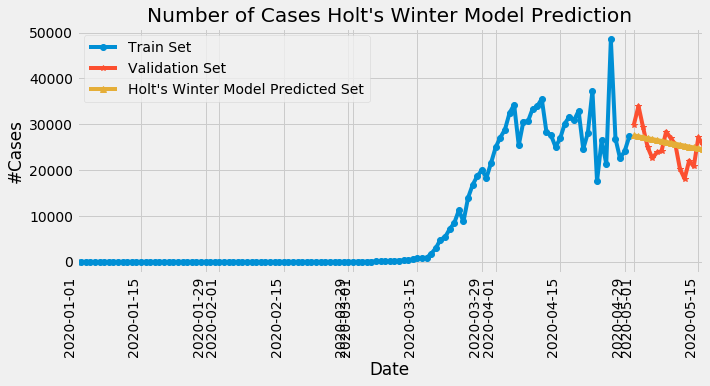

In [41]:
holt=Holt(np.asarray(train["new_cases"])).fit(smoothing_level=0.2, smoothing_slope=0.1,optimized=False)
y_pred=valid.copy()

y_pred["Holt"]=holt.forecast(len(valid))

print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["new_cases"],y_pred["Holt"])))

plt.figure(figsize=(10,5))
plt.plot(train.new_cases,label="Train Set",marker='o')
valid.new_cases.plot(label="Validation Set",marker='*')
y_pred["Holt"].plot(label="Holt's Winter Model Predicted Set",marker='^')
plt.ylabel("#Cases")
plt.xlabel("Date")
plt.title("Number of Cases Holt's Winter Model Prediction")
plt.xticks(rotation=90)
plt.legend()